
# Using the GLM for Classification
In this notebook we test the GLM for binary classification on the USPS handwritten digits dataset. We compare to select models in scikit learn too.

In [1]:
%matplotlib inline
import logging
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as pl
pl.style.use('ggplot')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from revrand import GeneralizedLinearModel, Parameter, Positive
from revrand.utils.datasets import fetch_gpml_usps_resampled_data
from revrand.basis_functions import RandomRBF
from revrand.likelihoods import Bernoulli
from revrand.optimize import AdaDelta, Adam

# Log output to the terminal attached to this notebook
logging.basicConfig(level=logging.INFO)

### Settings

In [2]:
# Which digits to classify
dig1 = 3
dig2 = 5

# Algorith settings
nbases = 800
lenscale = gamma(1, scale=6.)
random_state = 150
nsamples = 50
maxiter = 10000
updater = Adam(epsilon=1e-8)

# Bounded variables
lenscale_init = Parameter(lenscale, Positive())

# Feature Transform
basis = RandomRBF(nbases, 256, lenscale=lenscale_init, random_state=random_state)

# SVR settings
svc_params = {
    'gamma': np.logspace(-1, 2, 10),
    'C': np.linspace(0.1, 10, 5)
}

# Gaussian Process settings
n_restarts = 10
kernel = 1**2 * RBF(length_scale=lenscale.mean(), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()

### Get and load data

In [3]:
# Fetch/load
usps_resampled = fetch_gpml_usps_resampled_data()

# Training dataset
ind_fals = usps_resampled.train.targets == dig1
ind_true = usps_resampled.train.targets == dig2
ind_all = np.logical_or(ind_fals, ind_true) 

X = usps_resampled.train.data[ind_all]
Y = (usps_resampled.train.targets[ind_all] == dig2).astype(float)

# Test dataset
ind_fals = usps_resampled.test.targets == dig1
ind_true = usps_resampled.test.targets == dig2
ind_all = np.logical_or(ind_fals, ind_true) 

Xs = usps_resampled.test.data[ind_all]
Ys = (usps_resampled.test.targets[ind_all] == dig2).astype(float)


### Classify using *revrand*

In [4]:
llhood = Bernoulli()
glm = GeneralizedLinearModel(llhood,
                             basis,
                             random_state=random_state,
                             maxiter=maxiter,
                             nsamples=nsamples,
                             updater=updater
                             )
glm.fit(X, Y)

# Predict
pys_l = glm.predict(Xs)
pys_l = np.vstack((1 - pys_l, pys_l)).T
Eys_l = pys_l[:, 0] > 0.5

INFO:revrand.glm:Optimising parameters...
INFO:revrand.optimize.decorators:Evaluating random starts...
INFO:revrand.glm:Random starts: Iter -500: ELBO = -5656.793211685731, reg = 0.253406216378982, like_hypers = [], basis_hypers = 7.295168991387261
INFO:revrand.optimize.decorators:Best start found with objective = 1615.2967163964163
INFO:revrand.glm:Iter 0: ELBO = -1767.987652533809, reg = 2.2810477010071613, like_hypers = [], basis_hypers = 6.25412680989254
INFO:revrand.glm:Iter 500: ELBO = -499.0590802366584, reg = 3.5565383048981993, like_hypers = [], basis_hypers = 4.778698299921703
INFO:revrand.glm:Iter 1000: ELBO = -515.209497150816, reg = 4.406957974022703, like_hypers = [], basis_hypers = 4.569620764563347
INFO:revrand.glm:Iter 1500: ELBO = -409.28094979085705, reg = 5.039283430995326, like_hypers = [], basis_hypers = 4.613621946779851
INFO:revrand.glm:Iter 2000: ELBO = -445.357983449804, reg = 5.582208540765181, like_hypers = [], basis_hypers = 4.808277678337811
INFO:revrand.g

### Classify using *Scikit Learn* Logistic regression with bases

In [5]:
lreg = LogisticRegression(penalty='l2', class_weight='balanced')
lreg.fit(basis.transform(X, lenscale.mean()), Y)

pys_r = lreg.predict_proba(basis.transform(Xs, lenscale.mean()))
Eys_r = 1 - lreg.predict(basis.transform(Xs, lenscale.mean()))

### Classify using *Scikit Learn* SVC

In [6]:
svc = GridSearchCV(SVC(class_weight='balanced', probability=True), svc_params, n_jobs=-1)
svc.fit(X, Y)

pys_s = svc.predict_proba(Xs)
Eys_s = 1 - svc.predict(Xs)

### Classify using *Scikit Learn* GPC

In [7]:
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=n_restarts)
gpc.fit(X, Y)

pys_g = gpc.predict_proba(Xs)
Eys_g = 1 - gpc.predict(Xs)

### Classify using *Scikit Learn* Random Forest

In [8]:
rfc = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=random_state)
rfc.fit(X, Y)

pys_f = rfc.predict_proba(Xs)
Eys_f = 1 - rfc.predict(Xs)

### Score results

In [9]:
def print_scores(alg_name, y_true, y_pred, y_prob):
    print("{}: av log loss = {:.4f}, error rate = {:.4f}"
          .format(alg_name,
                  log_loss(y_true, y_prob),
                  accuracy_score(y_true, y_pred)
                 )
         )

print_scores('GLM', Ys, Eys_l, pys_l)
print_scores('Logistic', Ys, Eys_r, pys_r)
print_scores('SVC', Ys, Eys_s, pys_s)
print_scores('GPC', Ys, Eys_g, pys_g)
print_scores('RFC', Ys, Eys_f, pys_f)

GLM: av log loss = 0.1138, error rate = 0.0207
Logistic: av log loss = 0.1734, error rate = 0.0362
SVC: av log loss = 0.1008, error rate = 0.0699
GPC: av log loss = 0.1405, error rate = 0.0259
RFC: av log loss = 0.1368, error rate = 0.0272


### Distribution of probabilistic outputs

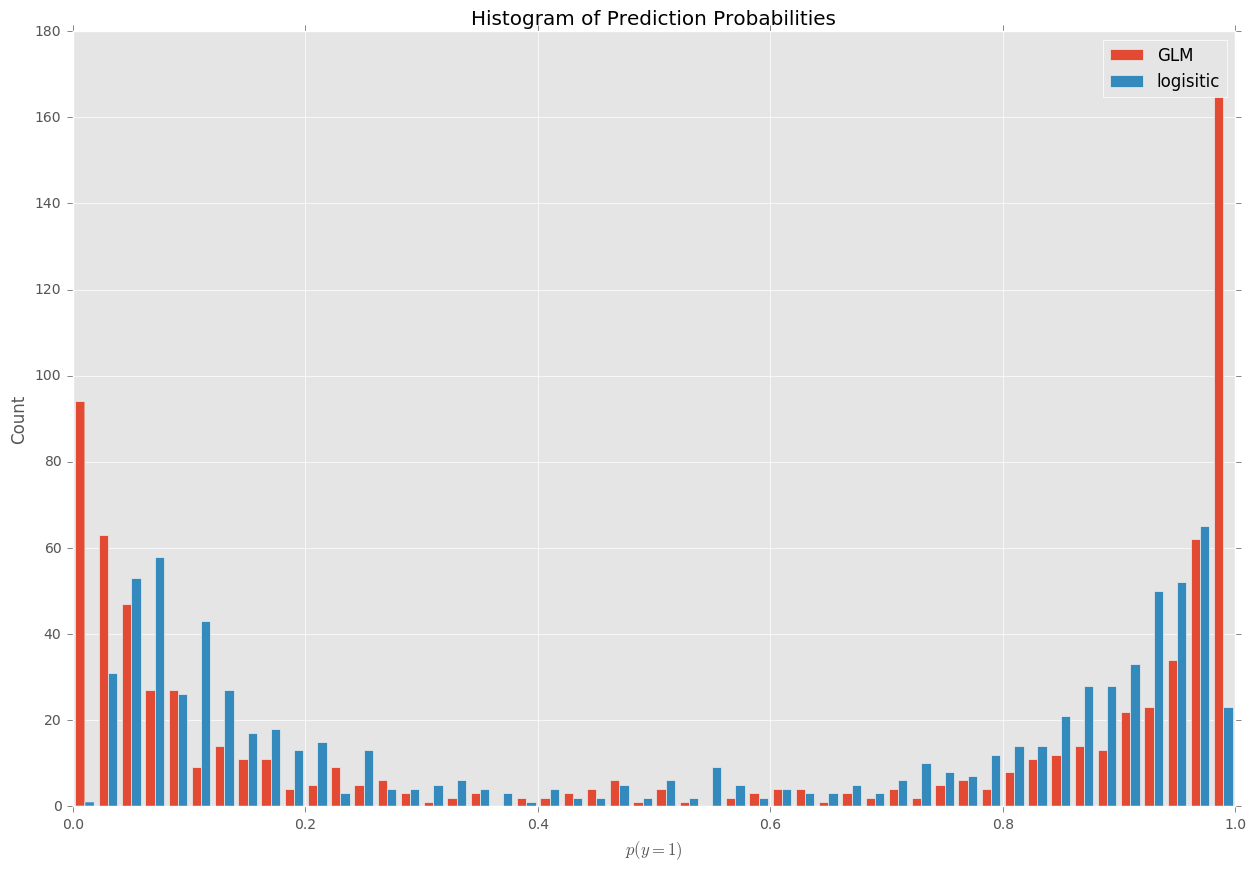

In [10]:
Ns = len(Xs)
pl.figure(figsize=(15, 10))
pl.hist([pys_l[:, 0], pys_r[:, 0]], 50, label=['GLM', 'logisitic'])
pl.ylabel('Count')
pl.xlabel('$p(y = 1)$')
pl.title('Histogram of Prediction Probabilities')
pl.legend()
pl.show()
